<a href="https://colab.research.google.com/github/aldoalprak/Mask_NoMask_Classification/blob/master/mask_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Library

In [0]:
%tensorflow_version 2.x

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!ls  "/content/drive/My Drive/Mask_Datasets/"

Model  Train  Validation


### Tensorflow JS

In [4]:
pip install tensorflowjs

     |████████████████████████████████| 61kB 1.8MB/s 
     |████████████████████████████████| 92kB 4.0MB/s 
     |████████████████████████████████| 144.4MB 80kB/s 
     |████████████████████████████████| 256kB 39.8MB/s 
     |████████████████████████████████| 921kB 32.7MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32851 sha256=4b1e6a517016640e7fe0dac5bea495882861cfd900ce18d46e23d2b4c829c277
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built PyInquirer
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: tensorflow-hub 0.8.0
    Uninstalling tensorflow-hub-0.8.0:
      Successfully uninstalled tensorflow-hub-0.8.0
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Found existing installation:

In [5]:
!tensorflowjs_converter --version


tensorflowjs 1.7.4r1

Dependency versions:
  keras 2.3.0-tf
  tensorflow 2.2.0


### Processing

In [0]:
#define directory

base_dir = "/content/drive/My Drive/Mask_Datasets/"

train_dir = os.path.join(base_dir, "Train")
train_mask_dir = os.path.join(train_dir, "Mask")
train_no_mask_dir = os.path.join(train_dir, "No_mask")

val_dir = os.path.join(base_dir, "Validation")
val_mask_dir = os.path.join(val_dir, "Mask")
val_no_mask_dir = os.path.join(val_dir, "No_mask")


In [7]:
#Understanding the data

num_mask_train = len(os.listdir(train_mask_dir))
num_no_mask_train = len(os.listdir(train_no_mask_dir))
total_train = num_mask_train + num_no_mask_train

num_mask_val = len(os.listdir(val_mask_dir))
num_no_mask_val = len(os.listdir(val_no_mask_dir))
total_val = num_mask_val + num_no_mask_val

print("train data: mask ==> ", num_mask_train)
print("train data: no_mask ==> ", num_no_mask_train)
print("total train data ==> ", total_train)
print("                      ")
print("validation data: mask ==> ", num_mask_val)
print("validation data: no_mask ==> ", num_no_mask_val)
print("total validation data ==> ", total_val)


train data: mask ==>  350
train data: no_mask ==>  400
total train data ==>  750
                      
validation data: mask ==>  150
validation data: no_mask ==>  200
total validation data ==>  350


In [0]:
batch_size = 100
epochs = 10
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [9]:
#Data Preparation

train_image_generator = ImageDataGenerator(
                          rescale=1./255, 
                          horizontal_flip=True,
                          rotation_range=45,
                          shear_range=0.3,
                          zoom_range=0.3,
                          width_shift_range=.15,
                          height_shift_range=.15,
                        )

train_data_gen = train_image_generator.flow_from_directory(
    batch_size = batch_size,
    directory = train_dir,
    shuffle = True,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode="binary"
)

val_image_generator = ImageDataGenerator(rescale=1./255)

val_data_gen = val_image_generator.flow_from_directory(
    batch_size = batch_size,
    directory = val_dir,
    shuffle = True,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode="binary"
)


Found 750 images belonging to 2 classes.
Found 350 images belonging to 2 classes.


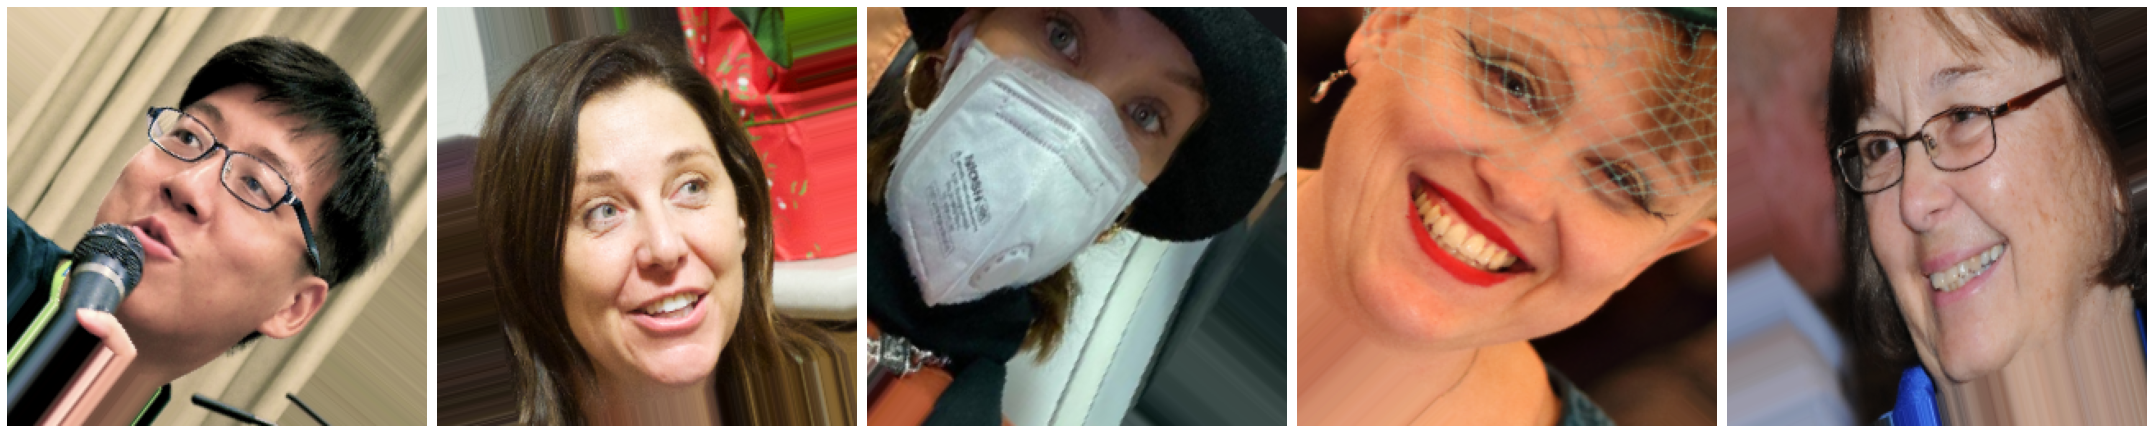

In [10]:
#visualize dataset
sample_training_image, _ = next(train_data_gen)

def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(30,30))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis("off")
  plt.tight_layout()
  plt.show()

plotImages(sample_training_image[:5])

In [0]:
#model

convolutional_block = convolutional_blocks = [
  Conv2D(32,(3,3), activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  MaxPooling2D(pool_size=(2,2)),
  Conv2D(64, (3,3), activation="relu"),
  MaxPooling2D(pool_size=(2,2)),
  Conv2D(64, (3,3), activation="relu"),
  MaxPooling2D(pool_size=(2,2)),
  Conv2D(128,(3,3), activation="relu"),
  MaxPooling2D(pool_size=(2,2)),
  Conv2D(128,(3,3), activation="relu"),
  MaxPooling2D(pool_size=(2,2)),
  Flatten(),
  Dense(512, activation="relu"),
  Dense(1, activation="sigmoid")
]

model = Sequential(convolutional_blocks)

In [0]:
## compile

model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       7

In [14]:
history = model.fit(
    train_data_gen,
    steps_per_epoch= total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps= total_val // batch_size
)

Epoch 1/10
7/7 [==============================] - 358s 51s/step - loss: 0.6955 - accuracy: 0.4662 - val_loss: 0.6858 - val_accuracy: 0.4333
Epoch 2/10
7/7 [==============================] - 106s 15s/step - loss: 0.6688 - accuracy: 0.4938 - val_loss: 0.6304 - val_accuracy: 0.4667
Epoch 3/10
7/7 [==============================] - 105s 15s/step - loss: 0.6363 - accuracy: 0.6723 - val_loss: 0.5721 - val_accuracy: 0.8833
Epoch 4/10
7/7 [==============================] - 105s 15s/step - loss: 0.6003 - accuracy: 0.7862 - val_loss: 0.5213 - val_accuracy: 0.9033
Epoch 5/10
7/7 [==============================] - 104s 15s/step - loss: 0.5772 - accuracy: 0.8092 - val_loss: 0.5709 - val_accuracy: 0.7500
Epoch 6/10
7/7 [==============================] - 106s 15s/step - loss: 0.5793 - accuracy: 0.8015 - val_loss: 0.5183 - val_accuracy: 0.8900
Epoch 7/10
7/7 [==============================] - 105s 15s/step - loss: 0.5543 - accuracy: 0.8600 - val_loss: 0.5242 - val_accuracy: 0.8767
Epoch 8/10
7/7 [====

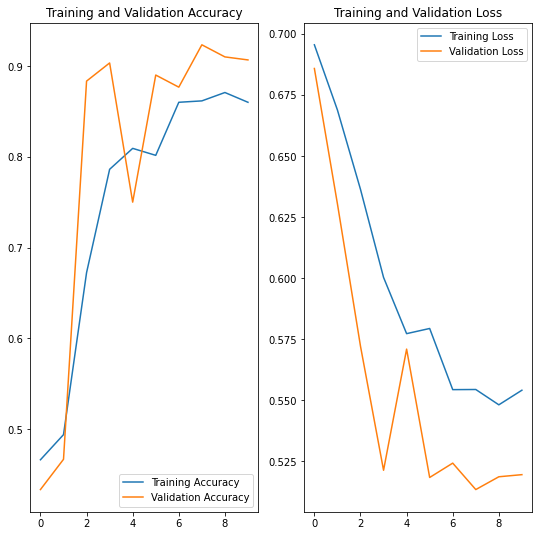

In [15]:
#plot loss & acc

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(9, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
evaluate = model.evaluate(val_data_gen, steps=total_val/batch_size)
print(evaluate)

4/3 [==================================] - 14s 3s/step - loss: 0.5196 - accuracy: 0.9086
[0.5196016430854797, 0.9085714221000671]


### Saving the model

In [0]:
tfjs_target_dir = "/content/drive/My Drive/Mask_Datasets/Model/"

In [0]:
import tensorflowjs as tfjs

In [19]:
tfjs.converters.save_keras_model(model, tfjs_target_dir)

/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:122: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)
